# Exploratory Data Analysis: Disease Status Prediction for Hospital Patients

## Overview
This notebook performs comprehensive exploratory data analysis on patient admission data and laboratory test results from Toronto hospitals. The goal is to understand patterns, distributions, and relationships in the data before building predictive models.

## Contents
1. Data Loading and Initial Inspection
2. Data Quality Assessment
3. Univariate Analysis
4. Bivariate Analysis
5. Multivariate Analysis
6. Temporal Analysis
7. Lab Test Analysis
8. Key Insights and Summary

## 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from datetime import datetime

warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Data Loading

In [2]:
admin_site1 = pd.read_csv('input/administrative_site1.csv')
admin_site2 = pd.read_csv('input/administrative_site2.csv')
lab = pd.read_csv('input/lab.csv')

print("Data loaded successfully!")
print(f"\nAdmin Site 1: {admin_site1.shape[0]} records, {admin_site1.shape[1]} columns")
print(f"Admin Site 2: {admin_site2.shape[0]} records, {admin_site2.shape[1]} columns")
print(f"Lab Data: {lab.shape[0]} records, {lab.shape[1]} columns")

Data loaded successfully!

Admin Site 1: 787 records, 9 columns
Admin Site 2: 1213 records, 9 columns
Lab Data: 3000 records, 8 columns


## 3. Data Structure and Schema

In [3]:
print("=" * 80)
print("ADMINISTRATIVE SITE 1 - Column Names and Types")
print("=" * 80)
print(admin_site1.dtypes)
print("\n" + "=" * 80)
print("ADMINISTRATIVE SITE 2 - Column Names and Types")
print("=" * 80)
print(admin_site2.dtypes)
print("\n" + "=" * 80)
print("LAB DATA - Column Names and Types")
print("=" * 80)
print(lab.dtypes)

ADMINISTRATIVE SITE 1 - Column Names and Types
ID                  int64
admission_date     object
admission_time     object
discharge_date     object
discharge_time     object
hospital_ID        object
gender             object
age               float64
disease_status      int64
dtype: object

ADMINISTRATIVE SITE 2 - Column Names and Types
subjectid           int64
admission.date     object
admission.time     object
discharge.date     object
discharge.time     object
hospital           object
gender             object
age               float64
disease.status      int64
dtype: object

LAB DATA - Column Names and Types
ID                 int64
test_name         object
test_code         object
result_unit       object
result_value     float64
result_date       object
result_time       object
provider_name     object
dtype: object


### Combine Administrative Data
The two administrative datasets have the same information but different column names. Let's standardize and combine them.

In [4]:
admin = pd.concat([
    admin_site1,
    admin_site2.rename(columns=dict(zip(admin_site2.columns, admin_site1.columns)))
], ignore_index=True)

print(f"Combined administrative data: {admin.shape[0]} records")
print(f"\nColumn names:\n{list(admin.columns)}")

Combined administrative data: 2000 records

Column names:
['ID', 'admission_date', 'admission_time', 'discharge_date', 'discharge_time', 'hospital_ID', 'gender', 'age', 'disease_status']


## 4. Data Quality Assessment

In [5]:
def data_quality_report(df, name):
    print(f"\n{'='*80}")
    print(f"DATA QUALITY REPORT: {name}")
    print(f"{'='*80}\n")
    
    print(f"Total Records: {len(df):,}")
    print(f"Total Features: {len(df.columns)}")
    print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print(f"\n{'Missing Values':-^80}")
    missing = pd.DataFrame({
        'Missing Count': df.isnull().sum(),
        'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
    })
    missing = missing[missing['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    if len(missing) > 0:
        print(missing)
    else:
        print("No missing values found!")
    
    print(f"\n{'Duplicate Records':-^80}")
    duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates} ({duplicates/len(df)*100:.2f}%)")
    
    print(f"\n{'Data Types':-^80}")
    print(df.dtypes.value_counts())

data_quality_report(admin, "Administrative Data")
data_quality_report(lab, "Laboratory Data")


DATA QUALITY REPORT: Administrative Data

Total Records: 2,000
Total Features: 9

Memory Usage: 0.80 MB

---------------------------------Missing Values---------------------------------
        Missing Count  Percentage
age               400      20.000
gender            300      15.000

-------------------------------Duplicate Records--------------------------------
Number of duplicate rows: 0 (0.00%)

-----------------------------------Data Types-----------------------------------
object     6
int64      2
float64    1
Name: count, dtype: int64

DATA QUALITY REPORT: Laboratory Data

Total Records: 3,000
Total Features: 8

Memory Usage: 1.18 MB

---------------------------------Missing Values---------------------------------
No missing values found!

-------------------------------Duplicate Records--------------------------------
Number of duplicate rows: 0 (0.00%)

-----------------------------------Data Types-----------------------------------
object     6
int64      1
float64    1

## 5. Descriptive Statistics

In [6]:
admin['discharge_date'] = pd.to_datetime(admin['discharge_date'], format='mixed', dayfirst=False)
admin['admission_date'] = pd.to_datetime(admin['admission_date'], format='mixed', dayfirst=False)
admin['length_of_stay'] = (admin['discharge_date'] - admin['admission_date']).dt.days

print("=" * 80)
print("DESCRIPTIVE STATISTICS - Administrative Data")
print("=" * 80)
print(admin[['age', 'length_of_stay', 'disease_status']].describe())

DESCRIPTIVE STATISTICS - Administrative Data
           age  length_of_stay  disease_status
count 1600.000        2000.000        2000.000
mean    59.178          99.365           0.487
std     14.186          56.966           0.500
min     35.000           1.000           0.000
25%     47.000          50.000           0.000
50%     59.000          99.000           0.000
75%     71.000         148.000           1.000
max     85.000         200.000           1.000


In [7]:
lab['result_date'] = pd.to_datetime(lab['result_date'], format='mixed', dayfirst=False)

print("=" * 80)
print("DESCRIPTIVE STATISTICS - Laboratory Data")
print("=" * 80)
print(lab[['result_value']].describe())

DESCRIPTIVE STATISTICS - Laboratory Data
       result_value
count      3000.000
mean        126.420
std         113.224
min           0.100
25%          57.350
50%         124.250
75%         142.825
max         598.700


## 6. Univariate Analysis

### 6.1 Target Variable: Disease Status

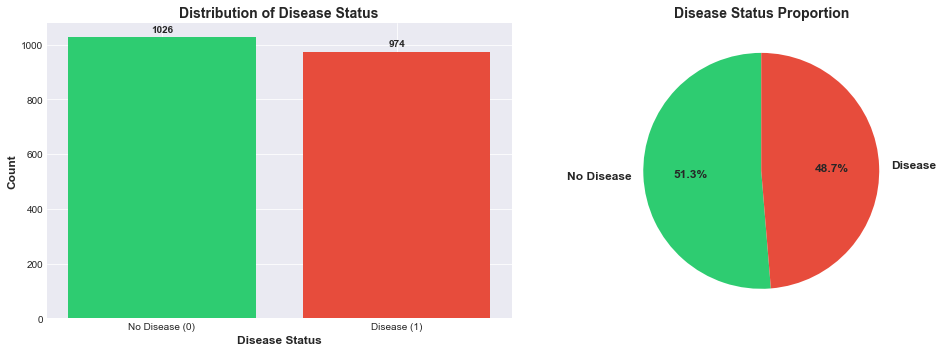

Class Balance:
disease_status
0    1026
1     974
Name: count, dtype: int64

Class Ratio: 0.949


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

disease_counts = admin['disease_status'].value_counts()
axes[0].bar(disease_counts.index, disease_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_xlabel('Disease Status', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Disease Status', fontsize=14, fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No Disease (0)', 'Disease (1)'])
for i, v in enumerate(disease_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

axes[1].pie(disease_counts.values, labels=['No Disease', 'Disease'], autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Disease Status Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Class Balance:")
print(disease_counts)
print(f"\nClass Ratio: {disease_counts[1]/disease_counts[0]:.3f}")

### 6.2 Age Distribution

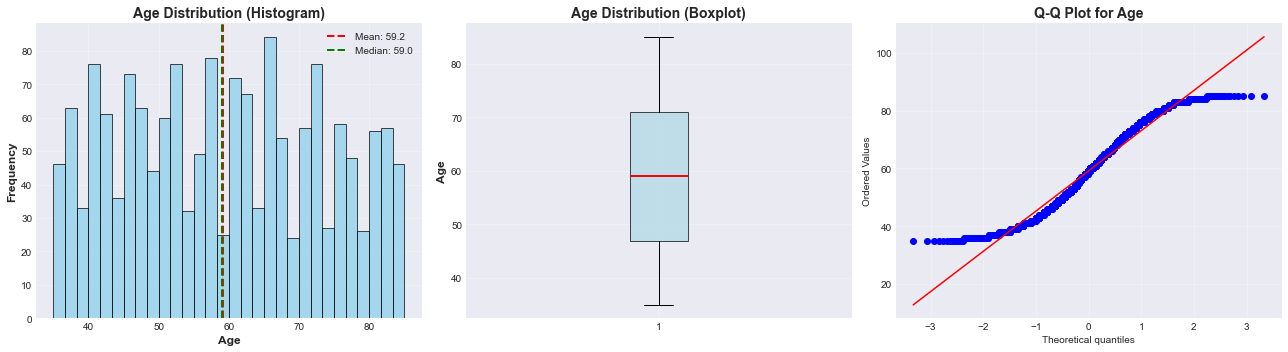

Age Statistics:
  Mean: 59.18
  Median: 59.00
  Std Dev: 14.19
  Range: [35, 85]
  Skewness: 0.086
  Kurtosis: -1.144


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(admin['age'].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(admin['age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {admin["age"].mean():.1f}')
axes[0].axvline(admin['age'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {admin["age"].median():.1f}')
axes[0].set_xlabel('Age', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Age Distribution (Histogram)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].boxplot(admin['age'].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Age', fontsize=12, fontweight='bold')
axes[1].set_title('Age Distribution (Boxplot)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

stats.probplot(admin['age'].dropna(), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot for Age', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Age Statistics:")
print(f"  Mean: {admin['age'].mean():.2f}")
print(f"  Median: {admin['age'].median():.2f}")
print(f"  Std Dev: {admin['age'].std():.2f}")
print(f"  Range: [{admin['age'].min():.0f}, {admin['age'].max():.0f}]")
print(f"  Skewness: {admin['age'].skew():.3f}")
print(f"  Kurtosis: {admin['age'].kurtosis():.3f}")

### 6.3 Length of Stay Distribution

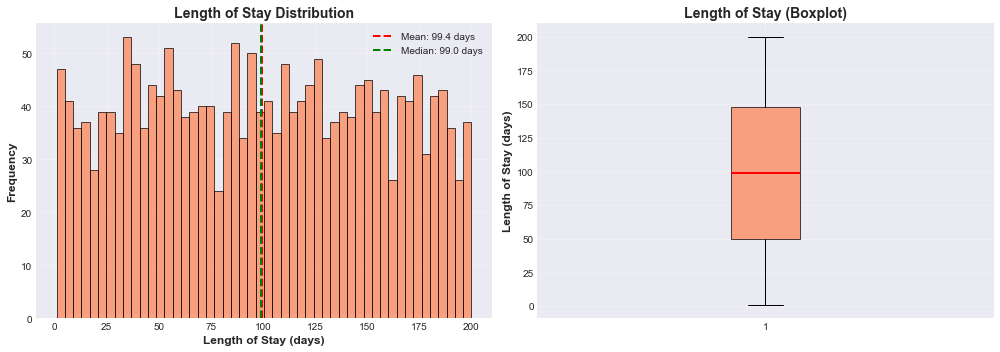

Length of Stay Statistics:
  Mean: 99.36 days
  Median: 99.00 days
  Std Dev: 56.97 days
  Range: [1, 200] days


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(admin['length_of_stay'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].axvline(admin['length_of_stay'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {admin["length_of_stay"].mean():.1f} days')
axes[0].axvline(admin['length_of_stay'].median(), color='green', linestyle='--', linewidth=2, 
                label=f'Median: {admin["length_of_stay"].median():.1f} days')
axes[0].set_xlabel('Length of Stay (days)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Length of Stay Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].boxplot(admin['length_of_stay'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='coral', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Length of Stay (days)', fontsize=12, fontweight='bold')
axes[1].set_title('Length of Stay (Boxplot)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Length of Stay Statistics:")
print(f"  Mean: {admin['length_of_stay'].mean():.2f} days")
print(f"  Median: {admin['length_of_stay'].median():.2f} days")
print(f"  Std Dev: {admin['length_of_stay'].std():.2f} days")
print(f"  Range: [{admin['length_of_stay'].min():.0f}, {admin['length_of_stay'].max():.0f}] days")

### 6.4 Gender Distribution

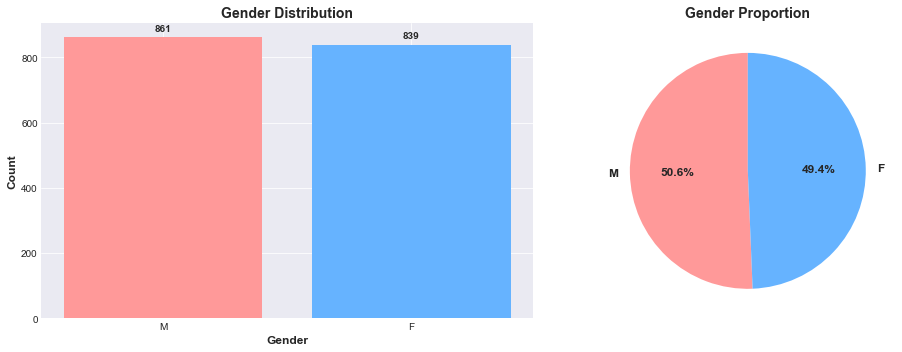

Gender Distribution:
gender
M    861
F    839
Name: count, dtype: int64


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

gender_counts = admin['gender'].value_counts()
axes[0].bar(gender_counts.index, gender_counts.values, color=['#ff9999', '#66b3ff'])
axes[0].set_xlabel('Gender', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Gender Distribution', fontsize=14, fontweight='bold')
for i, v in enumerate(gender_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

axes[1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
            colors=['#ff9999', '#66b3ff'], startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Gender Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Gender Distribution:")
print(gender_counts)

### 6.5 Hospital Distribution

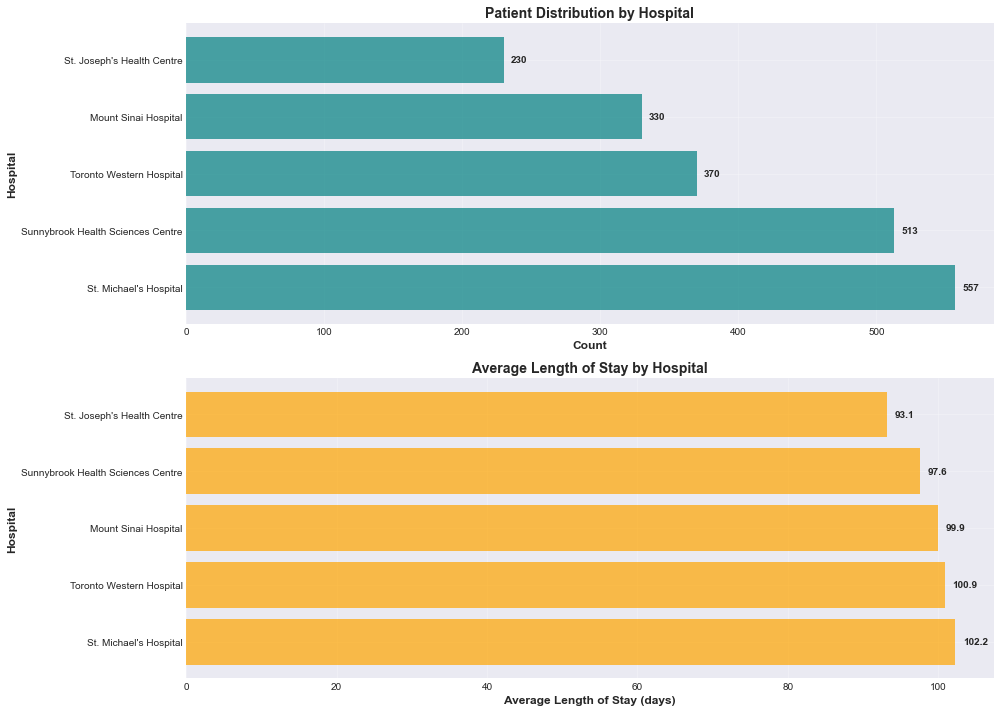


Hospital Statistics:
hospital_ID
St. Michael's Hospital               557
Sunnybrook Health Sciences Centre    513
Toronto Western Hospital             370
Mount Sinai Hospital                 330
St. Joseph's Health Centre           230
Name: count, dtype: int64


In [12]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

hospital_counts = admin['hospital_ID'].value_counts()
axes[0].barh(hospital_counts.index, hospital_counts.values, color='teal', alpha=0.7)
axes[0].set_xlabel('Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Hospital', fontsize=12, fontweight='bold')
axes[0].set_title('Patient Distribution by Hospital', fontsize=14, fontweight='bold')
for i, v in enumerate(hospital_counts.values):
    axes[0].text(v + 5, i, str(v), va='center', fontweight='bold')
axes[0].grid(alpha=0.3)

len_stay_by_hospital = admin.groupby('hospital_ID')['length_of_stay'].mean().sort_values(ascending=False)
axes[1].barh(len_stay_by_hospital.index, len_stay_by_hospital.values, color='orange', alpha=0.7)
axes[1].set_xlabel('Average Length of Stay (days)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Hospital', fontsize=12, fontweight='bold')
axes[1].set_title('Average Length of Stay by Hospital', fontsize=14, fontweight='bold')
for i, v in enumerate(len_stay_by_hospital.values):
    axes[1].text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nHospital Statistics:")
print(hospital_counts)

## 7. Bivariate Analysis

### 7.1 Disease Status vs Age

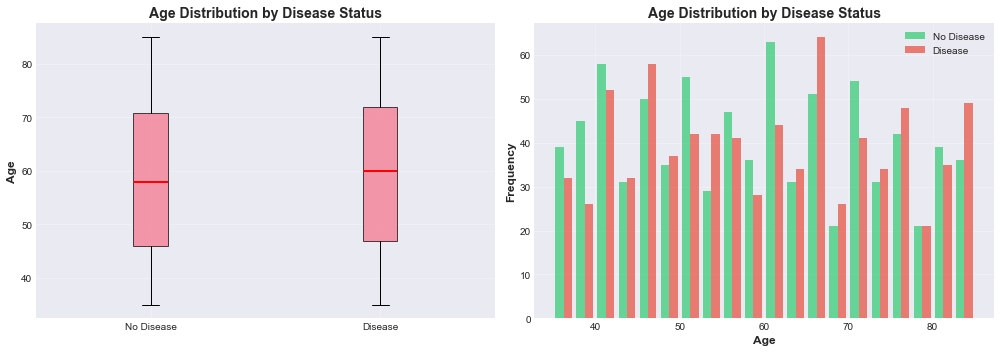

Age by Disease Status:
                 count   mean    std    min    25%    50%    75%    max
disease_status                                                         
0              814.000 58.600 14.174 35.000 46.000 58.000 70.750 85.000
1              786.000 59.776 14.182 35.000 47.000 60.000 72.000 85.000

T-test: t-statistic=-1.6595, p-value=0.0972
Result: No statistically significant difference in age between disease groups


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

admin_clean = admin.dropna(subset=['age'])
axes[0].boxplot([admin_clean[admin_clean['disease_status']==0]['age'],
                 admin_clean[admin_clean['disease_status']==1]['age']],
                labels=['No Disease', 'Disease'],
                patch_artist=True,
                boxprops=dict(alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[0].set_ylabel('Age', fontsize=12, fontweight='bold')
axes[0].set_title('Age Distribution by Disease Status', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist([admin_clean[admin_clean['disease_status']==0]['age'],
              admin_clean[admin_clean['disease_status']==1]['age']],
             bins=20, label=['No Disease', 'Disease'], alpha=0.7, color=['#2ecc71', '#e74c3c'])
axes[1].set_xlabel('Age', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Age Distribution by Disease Status', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Age by Disease Status:")
print(admin_clean.groupby('disease_status')['age'].describe())

from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(admin_clean[admin_clean['disease_status']==0]['age'].dropna(),
                             admin_clean[admin_clean['disease_status']==1]['age'].dropna())
print(f"\nT-test: t-statistic={t_stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("Result: Statistically significant difference in age between disease groups")
else:
    print("Result: No statistically significant difference in age between disease groups")

### 7.2 Disease Status vs Length of Stay

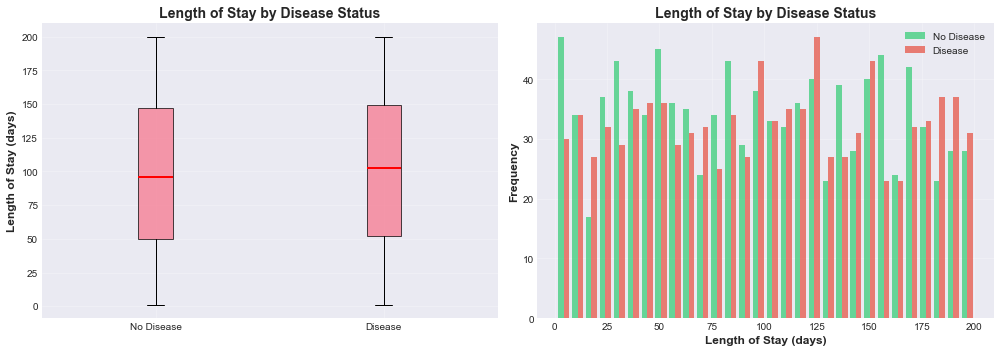

Length of Stay by Disease Status:
                  count    mean    std   min    25%     50%     75%     max
disease_status                                                             
0              1026.000  97.568 56.723 1.000 50.000  96.000 147.000 200.000
1               974.000 101.257 57.189 1.000 52.000 102.500 149.000 200.000

T-test: t-statistic=-1.4477, p-value=0.1479


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot([admin[admin['disease_status']==0]['length_of_stay'],
                 admin[admin['disease_status']==1]['length_of_stay']],
                labels=['No Disease', 'Disease'],
                patch_artist=True,
                boxprops=dict(alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[0].set_ylabel('Length of Stay (days)', fontsize=12, fontweight='bold')
axes[0].set_title('Length of Stay by Disease Status', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist([admin[admin['disease_status']==0]['length_of_stay'],
              admin[admin['disease_status']==1]['length_of_stay']],
             bins=30, label=['No Disease', 'Disease'], alpha=0.7, color=['#2ecc71', '#e74c3c'])
axes[1].set_xlabel('Length of Stay (days)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Length of Stay by Disease Status', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Length of Stay by Disease Status:")
print(admin.groupby('disease_status')['length_of_stay'].describe())

t_stat, p_value = ttest_ind(admin[admin['disease_status']==0]['length_of_stay'],
                             admin[admin['disease_status']==1]['length_of_stay'])
print(f"\nT-test: t-statistic={t_stat:.4f}, p-value={p_value:.4f}")

### 7.3 Disease Status vs Gender

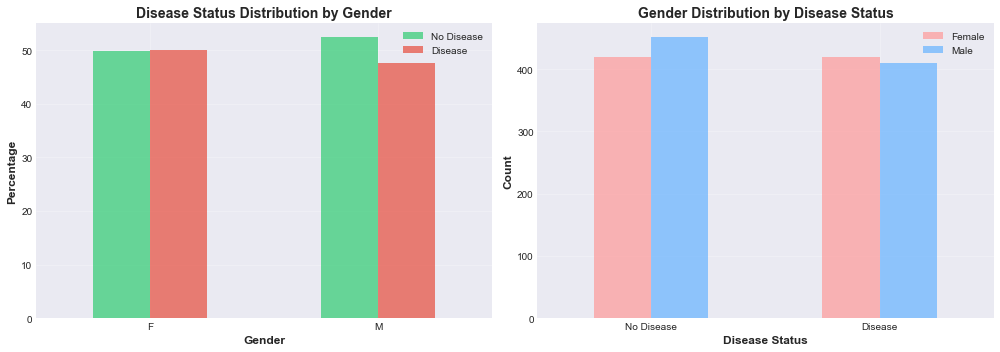

Cross-tabulation: Gender vs Disease Status
disease_status    0    1   All
gender                        
F               419  420   839
M               451  410   861
All             870  830  1700

Chi-square test: χ²=0.9176, p-value=0.3381


In [15]:
gender_disease = pd.crosstab(admin['gender'], admin['disease_status'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

gender_disease.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0].set_xlabel('Gender', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Percentage', fontsize=12, fontweight='bold')
axes[0].set_title('Disease Status Distribution by Gender', fontsize=14, fontweight='bold')
axes[0].legend(['No Disease', 'Disease'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(alpha=0.3)

disease_gender = pd.crosstab(admin['disease_status'], admin['gender'])
disease_gender.plot(kind='bar', ax=axes[1], color=['#ff9999', '#66b3ff'], alpha=0.7)
axes[1].set_xlabel('Disease Status', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Gender Distribution by Disease Status', fontsize=14, fontweight='bold')
axes[1].legend(['Female', 'Male'])
axes[1].set_xticklabels(['No Disease', 'Disease'], rotation=0)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Cross-tabulation: Gender vs Disease Status")
print(pd.crosstab(admin['gender'], admin['disease_status'], margins=True))

from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(admin['gender'], admin['disease_status']))
print(f"\nChi-square test: χ²={chi2:.4f}, p-value={p_value:.4f}")

### 7.4 Disease Status vs Hospital

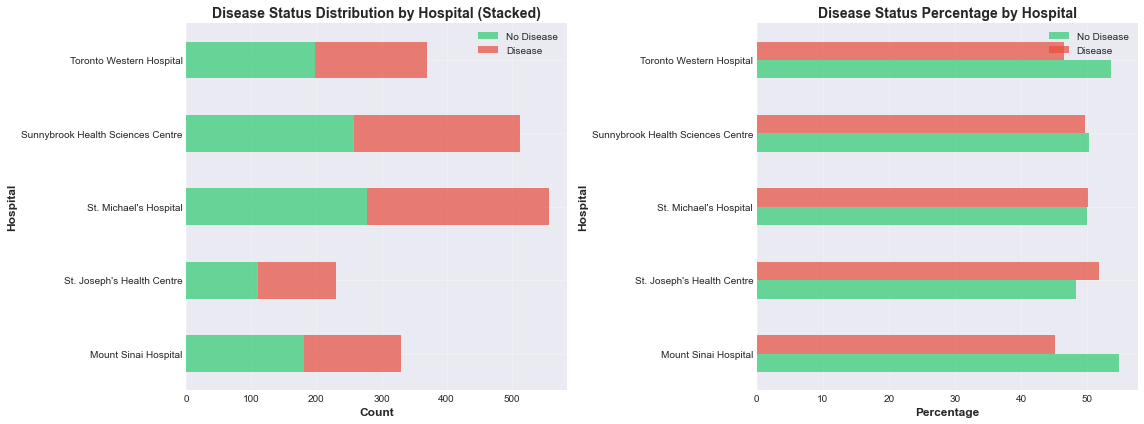

Disease Status by Hospital:
disease_status                       0    1
hospital_ID                                
Mount Sinai Hospital               181  149
St. Joseph's Health Centre         111  119
St. Michael's Hospital             278  279
Sunnybrook Health Sciences Centre  258  255
Toronto Western Hospital           198  172


In [16]:
hospital_disease = pd.crosstab(admin['hospital_ID'], admin['disease_status'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

hospital_disease.plot(kind='barh', ax=axes[0], color=['#2ecc71', '#e74c3c'], alpha=0.7, stacked=True)
axes[0].set_xlabel('Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Hospital', fontsize=12, fontweight='bold')
axes[0].set_title('Disease Status Distribution by Hospital (Stacked)', fontsize=14, fontweight='bold')
axes[0].legend(['No Disease', 'Disease'])
axes[0].grid(alpha=0.3)

hospital_disease_pct = pd.crosstab(admin['hospital_ID'], admin['disease_status'], normalize='index') * 100
hospital_disease_pct.plot(kind='barh', ax=axes[1], color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[1].set_xlabel('Percentage', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Hospital', fontsize=12, fontweight='bold')
axes[1].set_title('Disease Status Percentage by Hospital', fontsize=14, fontweight='bold')
axes[1].legend(['No Disease', 'Disease'])
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Disease Status by Hospital:")
print(hospital_disease)

## 8. Laboratory Test Analysis

In [17]:
print("=" * 80)
print("LABORATORY TEST OVERVIEW")
print("=" * 80)
print(f"\nTotal number of lab tests: {len(lab):,}")
print(f"Unique patients with lab tests: {lab['ID'].nunique():,}")
print(f"Average tests per patient: {len(lab)/lab['ID'].nunique():.2f}")
print(f"\nTest Types:")
print(lab['test_name'].value_counts())

LABORATORY TEST OVERVIEW

Total number of lab tests: 3,000
Unique patients with lab tests: 1,820
Average tests per patient: 1.65

Test Types:
test_name
Sodium plasma         1045
Urea plasma            472
Creatinine plasma      430
Potassium plasma       408
Chloride plasma        334
Bicarbonate plasma     311
Name: count, dtype: int64


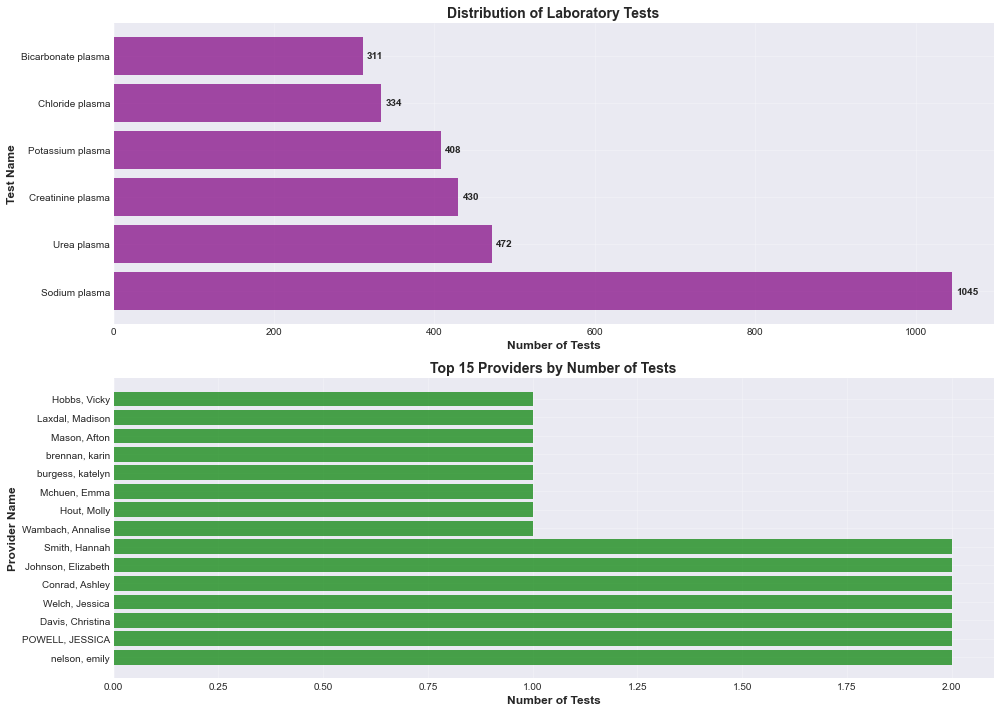

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

test_counts = lab['test_name'].value_counts()
axes[0].barh(test_counts.index, test_counts.values, color='purple', alpha=0.7)
axes[0].set_xlabel('Number of Tests', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Test Name', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Laboratory Tests', fontsize=14, fontweight='bold')
for i, v in enumerate(test_counts.values):
    axes[0].text(v + 5, i, str(v), va='center', fontweight='bold')
axes[0].grid(alpha=0.3)

provider_counts = lab['provider_name'].value_counts().head(15)
axes[1].barh(provider_counts.index, provider_counts.values, color='green', alpha=0.7)
axes[1].set_xlabel('Number of Tests', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Provider Name', fontsize=12, fontweight='bold')
axes[1].set_title('Top 15 Providers by Number of Tests', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 8.1 Laboratory Test Values Distribution

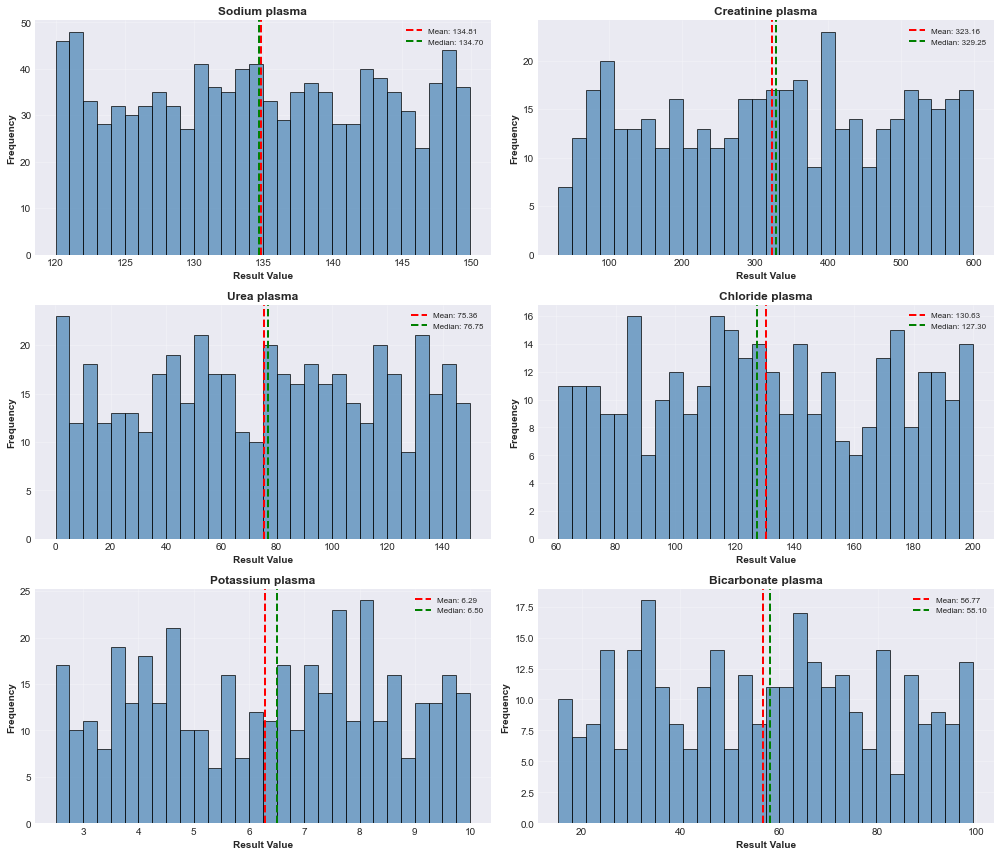


Laboratory Test Statistics by Test Type:

Sodium plasma:
  Count: 1045
  Mean: 134.81
  Median: 134.70
  Std Dev: 8.81
  Range: [120.00, 149.90]

Creatinine plasma:
  Count: 430
  Mean: 323.16
  Median: 329.25
  Std Dev: 163.12
  Range: [30.20, 598.70]

Urea plasma:
  Count: 472
  Mean: 75.36
  Median: 76.75
  Std Dev: 43.45
  Range: [0.10, 149.90]

Chloride plasma:
  Count: 334
  Mean: 130.63
  Median: 127.30
  Std Dev: 40.02
  Range: [60.80, 199.90]

Potassium plasma:
  Count: 408
  Mean: 6.29
  Median: 6.50
  Std Dev: 2.18
  Range: [2.50, 10.00]

Bicarbonate plasma:
  Count: 311
  Mean: 56.77
  Median: 58.10
  Std Dev: 23.76
  Range: [15.30, 99.30]


In [19]:
test_types = lab['test_name'].unique()
n_tests = len(test_types)
n_cols = 2
n_rows = (n_tests + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

for i, test in enumerate(test_types):
    test_data = lab[lab['test_name'] == test]['result_value']
    axes[i].hist(test_data, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].axvline(test_data.mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {test_data.mean():.2f}')
    axes[i].axvline(test_data.median(), color='green', linestyle='--', linewidth=2, 
                    label=f'Median: {test_data.median():.2f}')
    axes[i].set_xlabel('Result Value', fontsize=10, fontweight='bold')
    axes[i].set_ylabel('Frequency', fontsize=10, fontweight='bold')
    axes[i].set_title(f'{test}', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=8)
    axes[i].grid(alpha=0.3)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("\nLaboratory Test Statistics by Test Type:")
for test in test_types:
    test_data = lab[lab['test_name'] == test]['result_value']
    print(f"\n{test}:")
    print(f"  Count: {len(test_data)}")
    print(f"  Mean: {test_data.mean():.2f}")
    print(f"  Median: {test_data.median():.2f}")
    print(f"  Std Dev: {test_data.std():.2f}")
    print(f"  Range: [{test_data.min():.2f}, {test_data.max():.2f}]")

## 9. Temporal Analysis

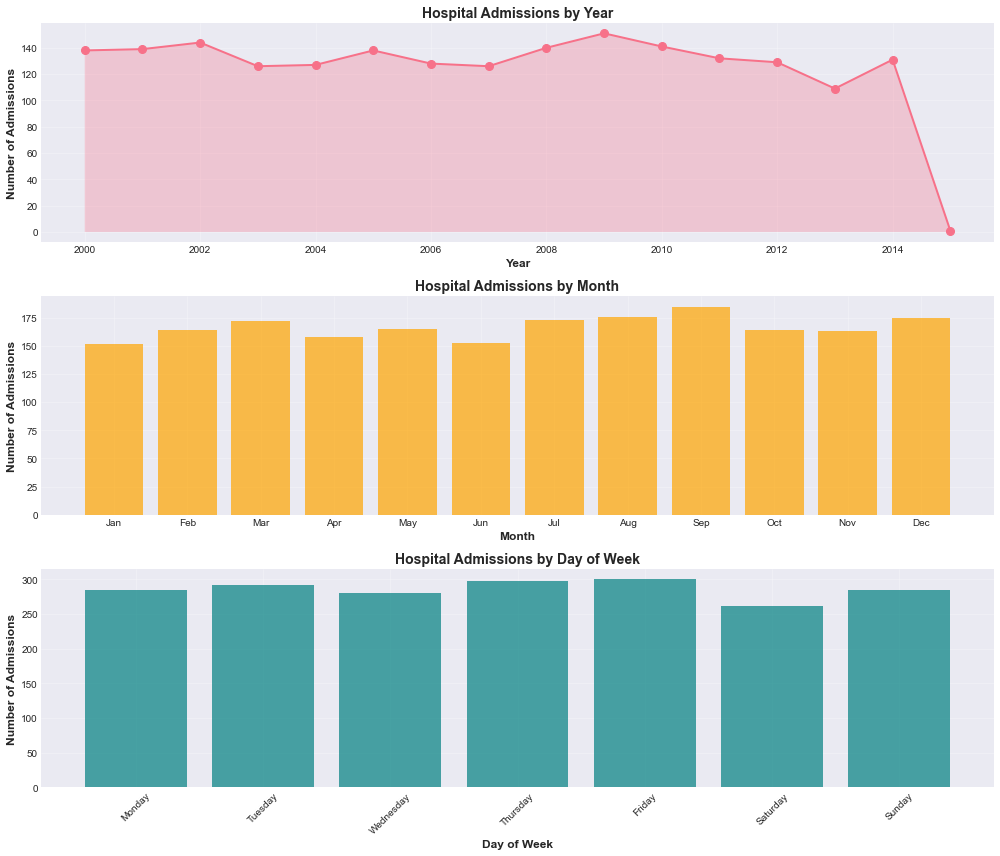

In [20]:
admin['admission_year'] = admin['admission_date'].dt.year
admin['admission_month'] = admin['admission_date'].dt.month
admin['admission_day_of_week'] = admin['admission_date'].dt.dayofweek

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

yearly_admissions = admin.groupby('admission_year').size()
axes[0].plot(yearly_admissions.index, yearly_admissions.values, marker='o', linewidth=2, markersize=8)
axes[0].fill_between(yearly_admissions.index, yearly_admissions.values, alpha=0.3)
axes[0].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Admissions', fontsize=12, fontweight='bold')
axes[0].set_title('Hospital Admissions by Year', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

monthly_admissions = admin.groupby('admission_month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1].bar(monthly_admissions.index, monthly_admissions.values, color='orange', alpha=0.7)
axes[1].set_xlabel('Month', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Admissions', fontsize=12, fontweight='bold')
axes[1].set_title('Hospital Admissions by Month', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names)
axes[1].grid(alpha=0.3)

dow_admissions = admin.groupby('admission_day_of_week').size()
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axes[2].bar(dow_admissions.index, dow_admissions.values, color='teal', alpha=0.7)
axes[2].set_xlabel('Day of Week', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Number of Admissions', fontsize=12, fontweight='bold')
axes[2].set_title('Hospital Admissions by Day of Week', fontsize=14, fontweight='bold')
axes[2].set_xticks(range(7))
axes[2].set_xticklabels(dow_names, rotation=45)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Correlation Analysis

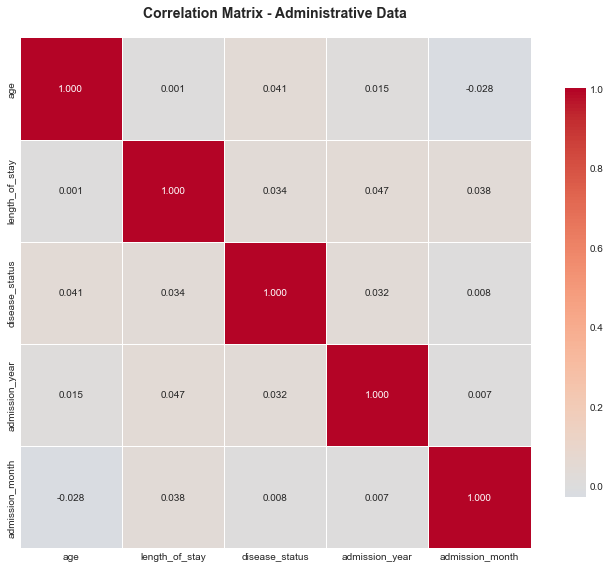


Correlation with Disease Status:
disease_status    1.000
age               0.041
length_of_stay    0.034
admission_year    0.032
admission_month   0.008
Name: disease_status, dtype: float64


In [21]:
admin_numeric = admin[['age', 'length_of_stay', 'disease_status', 'admission_year', 'admission_month']].dropna()

correlation_matrix = admin_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Administrative Data', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation with Disease Status:")
print(correlation_matrix['disease_status'].sort_values(ascending=False))

## 11. Key Insights and Summary

In [22]:
print("=" * 80)
print("KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS")
print("=" * 80)

print("\n1. DATASET OVERVIEW:")
print(f"   - Total patient records: {len(admin):,}")
print(f"   - Patients with disease: {admin['disease_status'].sum():,} ({admin['disease_status'].mean()*100:.1f}%)")
print(f"   - Patients without disease: {(1-admin['disease_status']).sum():,} ({(1-admin['disease_status']).mean()*100:.1f}%)")
print(f"   - Total lab tests: {len(lab):,}")
print(f"   - Unique patients with lab data: {lab['ID'].nunique():,}")

print("\n2. DATA QUALITY:")
print(f"   - Missing age values: {admin['age'].isna().sum()} ({admin['age'].isna().mean()*100:.1f}%)")
print(f"   - Missing gender values: {admin['gender'].isna().sum()} ({admin['gender'].isna().mean()*100:.1f}%)")
print(f"   - Complete records: {admin.dropna().shape[0]:,}")

print("\n3. PATIENT DEMOGRAPHICS:")
print(f"   - Average age: {admin['age'].mean():.1f} years")
print(f"   - Age range: {admin['age'].min():.0f} - {admin['age'].max():.0f} years")
print(f"   - Gender distribution: {admin['gender'].value_counts().to_dict()}")

print("\n4. HOSPITAL STATISTICS:")
print(f"   - Number of hospitals: {admin['hospital_ID'].nunique()}")
print(f"   - Average length of stay: {admin['length_of_stay'].mean():.1f} days")
print(f"   - Longest stay: {admin['length_of_stay'].max():.0f} days")
print(f"   - Shortest stay: {admin['length_of_stay'].min():.0f} days")

print("\n5. LABORATORY TESTS:")
print(f"   - Number of different test types: {lab['test_name'].nunique()}")
print(f"   - Most common test: {lab['test_name'].value_counts().index[0]}")
print(f"   - Average tests per patient: {len(lab)/lab['ID'].nunique():.2f}")

print("\n6. STATISTICAL FINDINGS:")
disease_yes = admin[admin['disease_status'] == 1]
disease_no = admin[admin['disease_status'] == 0]
print(f"   - Average age (disease): {disease_yes['age'].mean():.1f} years")
print(f"   - Average age (no disease): {disease_no['age'].mean():.1f} years")
print(f"   - Average LOS (disease): {disease_yes['length_of_stay'].mean():.1f} days")
print(f"   - Average LOS (no disease): {disease_no['length_of_stay'].mean():.1f} days")

print("\n7. NEXT STEPS:")
print("   - Feature engineering and preprocessing")
print("   - Handle missing values and outliers")
print("   - Merge administrative and lab data")
print("   - Build predictive models")
print("   - Model evaluation and comparison")
print("=" * 80)

KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS

1. DATASET OVERVIEW:
   - Total patient records: 2,000
   - Patients with disease: 974 (48.7%)
   - Patients without disease: 1,026 (51.3%)
   - Total lab tests: 3,000
   - Unique patients with lab data: 1,820

2. DATA QUALITY:
   - Missing age values: 400 (20.0%)
   - Missing gender values: 300 (15.0%)
   - Complete records: 1,371

3. PATIENT DEMOGRAPHICS:
   - Average age: 59.2 years
   - Age range: 35 - 85 years
   - Gender distribution: {'M': 861, 'F': 839}

4. HOSPITAL STATISTICS:
   - Number of hospitals: 5
   - Average length of stay: 99.4 days
   - Longest stay: 200 days
   - Shortest stay: 1 days

5. LABORATORY TESTS:
   - Number of different test types: 6
   - Most common test: Sodium plasma
   - Average tests per patient: 1.65

6. STATISTICAL FINDINGS:
   - Average age (disease): 59.8 years
   - Average age (no disease): 58.6 years
   - Average LOS (disease): 101.3 days
   - Average LOS (no disease): 97.6 days

7. NEXT STEPS:
   -